# Data Analysis

In [1]:
# Import basic libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.pandas.set_option('display.max_columns', None)

In [7]:
# Load dataset

data = pd.read_csv('train.csv')

print(data.shape)

data.head(5)

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# data types in the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Following the same order as proposed in the course we will identify:

1. Missing values
2. Numerical variables
3. Distribution of the numerical variables
4. Outliers
5. Categorical variables
6. Cardinality of the categorical variables
7. Potential relationship between the variables and the target: Survived

### Missing Values

In [9]:
# Find the variables that contains missing values
vars_na = [var for var in data.columns if data[var].isnull().sum() > 0]

# Calculate the percentage of missing values
data[vars_na].isnull().mean()

Age         0.198653
Cabin       0.771044
Embarked    0.002245
dtype: float64

Let's see what the impact is in our target variable *"Survived"* when considering the variables with missing data

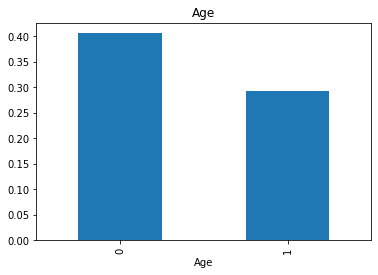

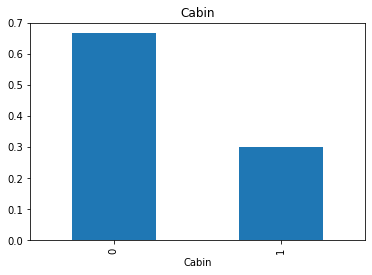

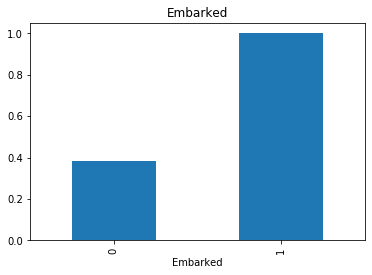

In [10]:
def impact_na_value (df, var):
    
    # Copy the original dataset to avoid changes on it 
    df = df.copy()
    
    # Create a variable with 1 if the observation is missing and 0 otherwise
    df[var] = np.where(df[var].isnull(), 1, 0)
    
    df.groupby(var)['Survived'].mean().plot.bar()
    
    plt.title(var)
    plt.show()
    
# Call the function for each variable
for var in vars_na:
    impact_na_value(data, var)

In Age, and Cabin variables the missing values contribute to lower the chances of surviving in the Titanic. However, in the embarked variable missing values contributes to survival.

### Numerical Variables

We can find the numerical variables in the dataset using data.info() but that method is limited when the dataset is low dimensional. The following method scales easily

In [15]:
# Make a list of numberical variabes
num_var = [var for var in data.columns if data[var].dtypes != 'O']

print('Number of numerical variables: ', len(num_var))

# Visualise numerical variables
data[num_var].head()

Number of numerical variables:  7


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1,0,3,22.0,1,0,7.2500
1,2,1,1,38.0,1,0,71.2833
2,3,1,3,26.0,0,0,7.9250
3,4,1,1,35.0,1,0,53.1000
4,5,0,3,35.0,0,0,8.0500


We can get rid of *PassengerID* as it seems it is a unique indicator:

In [17]:
print('Number of Unique Ids: ', len(data['PassengerId'].unique()))
print('Number of passengers in Titanic: ', len(data))

Number of Unique Ids:  891
Number of passengers in Titanic:  891


#### Numerical discrete variables

Let's identify those numerical variable that exhibit a discrete behaviour, i.e., show a finite number of values

In [19]:
# List of discrete variables
dis_var = [var for var in data.columns if data[var].dtypes != 'O'
          and len(data[var].unique()) < 20 and var != 'Survived']

print('Number of numerical discrete variables: ', len(dis_var))

# Visualise numerical variables
data[dis_var].head()

Number of numerical discrete variables:  3


,Pclass,SibSp,Parch
0,3,1,0
1,1,1,0
2,3,0,0
3,1,1,0
4,3,0,0


Let's see the analysis of these discrete variables

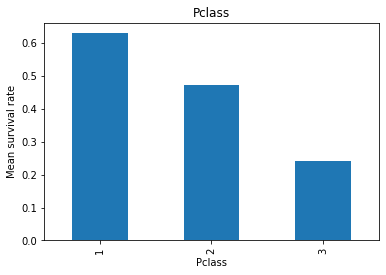

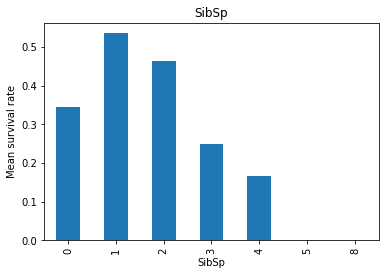

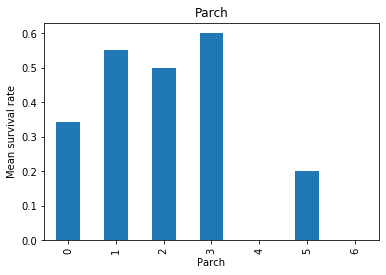

In [21]:
def dis_analysis(df, var):
    
    df = df.copy()
    df.groupby(var)['Survived'].mean().plot.bar()
    plt.title(var)
    plt.ylabel('Mean survival rate')
    plt.show()
    
for var in dis_var:
    dis_analysis(data, var)

The ticket class represented by *Pclass* clearly influences the likelihood of surviving in Titatic. First class more than doubles third class the likelihood of surviving.

*SibSp* denotes the number of siblings/spouses aboard the Titanic. 1 and 2 number of siblings/spouses makes it more likely for the passenger to survive.

*Parch* represents the number of parents/children in the Titanic. Having fewer children (up to 3) helped to survive. 

#### Numerical continious variables

Let's do the same with continious variables this time.

In [23]:
# List of continious variables
cont_var = [var for var in num_var if var not in dis_var and var != 'Survived'
           and var != 'PassengerId']

print('Number of numerical continious variables: ', len(cont_var))

# Visualise numerical variables
data[cont_var].head()

Number of numerical continious variables:  2


,Age,Fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500


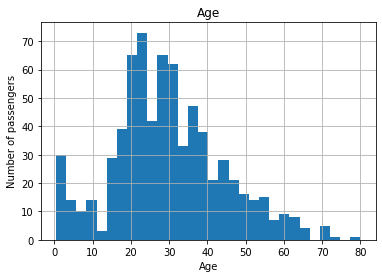

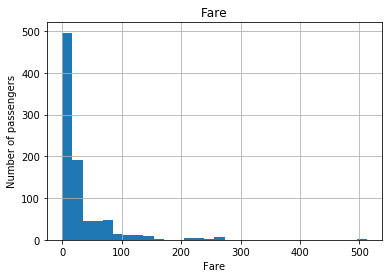

In [45]:
def cont_analysis(df, var):
    
    df = df.copy()
    df[var].hist(bins=30)
    plt.ylabel('Number of passengers')
    plt.xlabel(var)
    plt.title(var)
    plt.show()
    
for var in cont_var:
    cont_analysis(data, var)

The variables are not normally distributed.

The idea is to build a logistic regression model. This kind of model applies a sigmoid function to a linear combination of variables, therefore to optimize performance we want to work with normally distributed variables.

Let's try a logarithmic transformation.

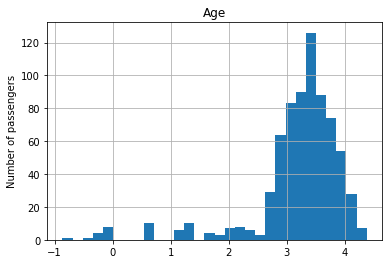

In [47]:
def trans_cont_var(df, var):
    
    df = df.copy()
    
    # Log is not defined with 0 or negative values, so let's avoid those.
    if any(df[var] <= 0):
        pass
    else:
        df[var] = np.log(df[var])
        df[var].hist(bins=30)
        plt.ylabel('Number of passengers')
        plt.title(var)
        plt.show()
        
for var in cont_var:
    trans_cont_var(data, var)

Log transformation can't be applied to *fare* variable as there are some negative values. On top of that, the age looks more similar to a normally distribution but there are extreme values out of the bulk of data.

Let's see how is the relationship with the transformed *age* variable and the *survived* target variable.

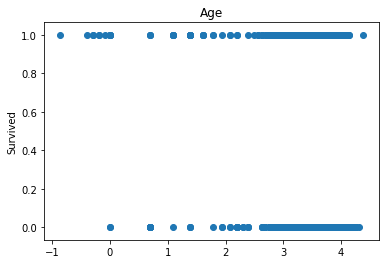

In [29]:
def cont_relationship(df, var):
    
    df = df.copy()
    if any(df[var] <=0):
        pass
    else:
        df[var] = np.log(df[var])
        plt.scatter(df[var], df['Survived'])
        plt.ylabel('Survived')
        plt.title(var)
        plt.show()
        
for var in cont_var:
    cont_relationship(data, var)

It is not clear from the scatter plot that age is a relevant factor in the survival of a passgener. 

### Outliers

Extreme values may affect the performance of a linear model. Therefore, it is necessary to discover if there are outliers in our data set by looking at the numerical continious variables

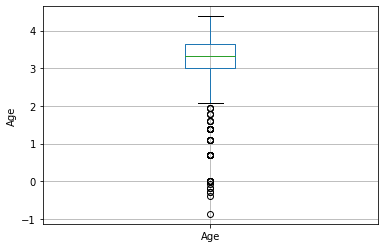

In [30]:
def outliers(df, var):
    
    df = df.copy()
    if any(data[var] <= 0):
        pass
    else:
        df[var] = np.log(df[var])
        df.boxplot(column=var)
        plt.ylabel(var)
        plt.show()
        
for var in cont_var:
    outliers(data, var)

The age variable seems to have some outliers, once it is transformed into a normal distribution. Let's take this into consideration when doing the feature engineering step.

### Categorical variables

Let's analyse now the categorical variables in the dataset.

In [50]:
# List of continious variables
cat_var = [var for var in data.columns if data[var].dtypes == 'O']

print('Number of categorical variables: ', len(cat_var))

# Visualise numerical variables
data[cat_var].head()

Number of categorical variables:  5


,Name,Sex,Ticket,Cabin,Embarked
0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
4,"Allen, Mr. William Henry",male,373450,NaN,S


#### Cardinality of categorical variables

Let's assess how many different classes are present in each of the variables

In [51]:
data[cat_var].nunique()

Name        891
Sex           2
Ticket      681
Cabin       147
Embarked      3
dtype: int64

*Sex* and *Embarked* variables exhibit low cardinality. Name is unique for each passenger so it makes sense that it is the same as the number of passengers. The fact that *Ticket* and *Cabin* are below 891 unique classes maybe due to several passengers sharing a group ticket and the same cabin.

#### Rare labels
Let's go ahead and explore now if there are labels present just in a few number of passengers. Although, using the insights so far it is reasonable to expect there won't be rare labels.

In [55]:
def rare_labels(df, var, perc):
    
    df = df.copy()
    
    # compute the % of observations per category
    rate = df.groupby(var)['Survived'].count()/len(df)
    
    # return categories that are rare
    return rate[rate < perc]

# print those categories that are present less that certain %

for var in cat_var:
    print(rare_labels(data, var, 0.001))
    print()

Series([], Name: Survived, dtype: float64)

Series([], Name: Survived, dtype: float64)

Series([], Name: Survived, dtype: float64)

Series([], Name: Survived, dtype: float64)

Series([], Name: Survived, dtype: float64)



The results depend on the threshold established to consider "rare" categories. For instance, considering that we should consider as "rare" those observation that contain a unique cabin number does not make sense, so we will not change the labels of the categorical variables.

Let's finish the data analysis with some plots that analyse how the categorical variables influence the target variable. We will use the same function that was applied to the numerical discrete variables.

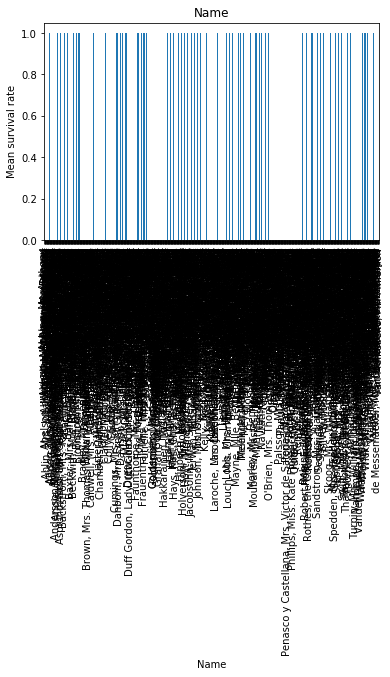

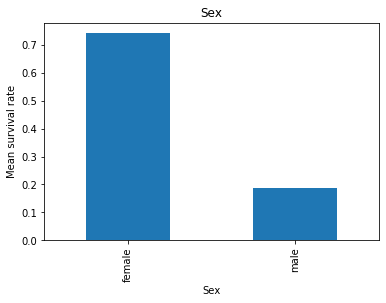

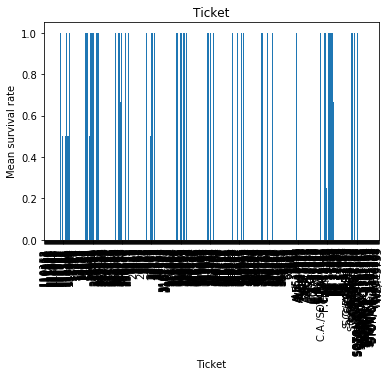

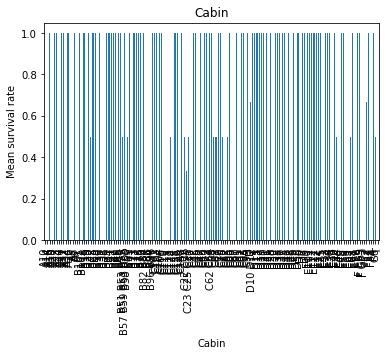

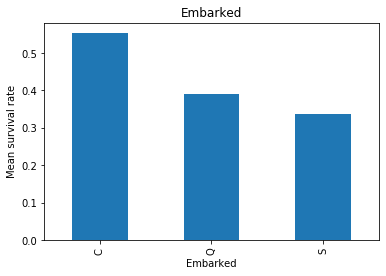

In [60]:
for var in cat_var:
    dis_analysis(data, var)

*Sex* and *Embarked* provide useful information about their effect on the target variable. 

It is clear that female passengers had a much greater survival rate than male passengers. 

The port of embarkation seems to affect as well the target variable. The people that embarked in Cherbour (C) had greater chances of surviving than those who embarked in Queenstown (Q) and SouthHampton (S).

Nonetheless, *Cabin*, *Ticket* and *Name* do not provide any useful information  as the are many unique values that can't be aggregated into a group. Besides that, the reason of being name John or David does not seem to affect the target variable. 

Based on that the best option would be to drop those variable in the feature selection stage.